# Feedforward Nerual Networks

In this notebook, we show how neral networks described in chapter 5 of PRML can be implemented. 

Because the notation of the book is a little sloppy, we first describe the formulation in detail, 
and then move to the corresponding code. 

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn import datasets, cross_validation, metrics

%matplotlib inline
mpl.rc("savefig",dpi=100)

C:\Users\sokohaku\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1 Setting

Let us define symbols as below: 
* $N \in \mathbb{N}$ : data size, 
* $d \in \mathbb{N}$ : the dimension of input, 
* $d_{out} \in \mathbb{N}$ : the dimension of output, 
* Denote input data by $x_1, x_2, \dots , x_N \in \mathbb{R}^d$, and outpu data by $t_1, t_2, \dots, t_N \in \mathbb{R}^{d_{out}}$. 

If we consider multiclass classification problem with $C$ classes, $t_1, t_2 \dots, t_N \in \left\{0,1\right\}$, where we employ 1-of-$C$ coding scheme. 

## 2 The representation of neural networks

We consider $L$-layer feedforward neural networks (feedforward neural networks with $L-1$ hidden layer) such as one shown in the following figure: 
@@@

For simplicity, we assume that there is no skip-layer connection, i.e.,  each elements in a layer is connected only to elements in its adjacent layers. 

In this section, we write down the definition of functions representing neural networks. Specifically, we decompose the function representing the neural network, so that we can extract contributions of parameters from a specified layer, for calculation of gradient in the next section, where we want differentiation with respect to parameters from each layer. 

### 2.1 The number of elements and the dimension

Let $n_l \in \mathbb{N}$ be the number of elements in the $l$th layer. 
It follows that $n_0 = d$, $n_L = d_{out}$.

### 2.2 Activation functions

Again for somplicity, we assume that activation functions for $l$th-layer with $l=1,2,\dots,L-1$ are all 
$h : \mathbb{R} \rightarrow \mathbb{R}$. $h$ can be, for example, logstic sigmoid function, tanh, ReLU and so on.
Also, we define $h^{(l)}$ by

\begin{equation}
    h^{(l)} : \mathbb{R}^{n_l} \rightarrow \mathbb{R}^{n_l}, \ \ 
    h^{(l)}(a) = (h(a_1), h(a_2), \dots, h(a_{n_l}))^T \ \in \mathbb{R}^{n_l}.
\end{equation}

Let us denote the activation function for the output layer by
$g : \mathbb{R}^{n_L} \rightarrow \mathbb{R}^{n_L}$. 

Concretely, $g$ is chosen as below:
* For binary classification, $g$ can be logistic sigmoid function. 
* For multiclass classification, $g$ can be softmax function.
* For regression, $g$ can be an identity map.


### 2.3 The input and output of each layer

Let us define
* $z^{(l)} \in \mathbb{R}^{n_l}$ : the output from the $l$-th layer
* $a^{(l)} \in \mathbb{R}^{n_{l+1}}$ : the input to the $l+1$

Then, 
\begin{equation}
    z^{(l)} = h^{(l)}(a^{(l-1)})
\end{equation}
follows. 

Let us also define parameters as follows
* $w^{(l)}_{i,j}$ : the weight of $j$-th element of $l$-th layer on the $i$-th element of$(l+1)$-th layer. 
* $b^{(l)}_{i}$ : the bias of $i$-th element of $(l+1)$-th layer.

If we define 
$w^{(l)} = (w^{(l)}_{i,j})_{i,j}$ ($n_{l+1} \times n_{l}$ matrix) and  
$b^{(l)} = (b^{(l)}_{1}, b^{(l)}_{2}, \dots, b^{(l)}_{n_{l+1}})^T$, 
then we have

\begin{equation}
    a^{(l)} = w^{(l)} z^{(l)} + b^{(l)}
\end{equation}

For later convenience, we denote this mapping by 
\begin{equation}
    A^{(l)}_{\theta^{(l)}} : \mathbb{R}^{n_{l}} \rightarrow \mathbb{R}^{n_{l+1}}  , \ \ A^{(l)}_{\theta^{(l)} }(z) := w^{(l)}z + b^{(l)}
\end{equation}, 
where $\theta^{(l)} := (w^{(l)}, b^{(l)})$.

### 2.4 The whole network

Let a function $f_{\theta} : \mathbb{R}^{d_{in}} \rightarrow \mathbb{R}^{d_{out}}$ be the function that represent the whole neural network we defined above. 

From the definitions above, it can be written as 

\begin{equation}
    f_{\theta} = g \circ A^{(L-1)}_{\theta^{(L-1)}} \circ h^{(L-1)} \circ A^{(L-2)}_{\theta^{(L-2)}} \circ \cdots 
        A^{(l+1)}_{\theta^{(l+1)}} \circ h^{(l+1)} \circ A^{(l)}_{\theta^{(l)}} \circ h^{(l)} \circ A^{(l-1)}_{\theta^{(l-1)}} 
        \circ \cdots \circ h^{(1)} \circ A^{(0)}_{\theta^{(0)}} . 
\end{equation}

Further, we can decompose the function as 
\begin{equation}
    f_{\theta} = F^{(l)} \circ A^{(l)}_{\theta^{(l)}}  \circ Z^{(l)} 
    \ \ (l = 0, \dots, L-1), 
\end{equation}

where

\begin{eqnarray}
    F^{(l)} &:=& g \circ A^{(L-1)}_{\theta^{(L-1)}} \circ h^{(L-1)} \circ A^{(L-2)}_{\theta^{(L-2)}} \circ \cdots 
        A^{(l+1)}_{\theta^{(l+1)}} \circ h^{(l+1)}  \ \ (l = 0,1, \dots, L-2) \\
    F^{(L-1)} &:=& g \\
    Z^{(l)} &:=& h^{(l)} \circ A^{(l-1)}_{\theta^{(l-1)}} \circ \cdots \circ h^{(1)} \circ A^{(0)}_{\theta^{(0)}}  \ \ (l = 1, \dots, L-1)\\
    Z^{(0)} &:=& I
\end{eqnarray}

Note that in the representation $f_{\theta} = F^{(l)} \circ A^{(l)}_{\theta^{(l)}}  \circ Z^{(l)} $, 
$A^{(l)}_{\theta^{(l)}}$ is the only part that parameters for $(l+1)$-th layer appear, 
which will simplify our calculation of gradients in the next section. 

## 3. Cost functions and the gradient (theory)

### 3.1 Cost functions

We assume that the cost function we want to minimize can be written as 

\begin{equation}
    E_{tot}(\theta) = \frac{1}{N} \sum_{n=1}^{N} E \left( f_{\theta}(x_n), t_n \right) + \frac{\lambda}{N} E_{reg}(\theta) , 
\end{equation}
where $\lambda E_{reg}(\theta)$ represents the regularization term, 
and $E$ is chosen appropriately depending on the problem: 
* For regression problem, $E$ can be $E(y,t) = \frac{1}{2} \| y - t \|^2$ and so on.
* For multiclass classification problem with $g$ being softmax functions, E can be $E(y,t) = -\sum_{k=1}^{d_{out}} t_k \log y_k$ (negative log likelihood).


### 3.2 Gradient 

Here, we calculate the gradient of the cost function with respect to parameters $w, b$. 
We consider the regularization term separately, and concentrate on the first term. 
Because this term has the form of summation over data, we can consider each data point separately. 

Although we skip the derivation (if I have enough time, I will typeset the derivation later...), which is straight forward, we can obtain the following equations for $l = 0,1,\dots, L-1$:

\begin{eqnarray}
    \delta^{(l)}_{i} &:=& \sum_{k=1}^{d_{out}} \left. \frac{\partial E}{\partial y_k} \right|_{y=f_{\theta}(x)} \cdot 
        \left. \frac{\partial F^{(l)}_{k}}{\partial a^{(l)}_{i}} \right|_{a^{(l)}= (A^{(l)} \circ Z^{(l)})(x) } \\
    \frac{\partial}{\partial w^{(l)}_{i,j}} E \left( f_{\theta}(x), t \right) &=& \delta^{(l)}_{i} Z^{(l)}_{j}(x) \\
    \frac{\partial}{\partial b^{(l)}_{i}} E \left( f_{\theta}(x), t \right) &=& \delta^{(l)}_{i} 
\end{eqnarray}

Here, $\delta^{(l)}_{i}$ represents how much the cost function changes when $a^{(l)}_{i}$, the input to the $i$-th element of $(l+1)$-th layer, changes slightly. 

Thus, to obtain the gradient, it is sufficient to calculate the quantities $\delta^{(l)}_{i}$. 
Back propagation is an algorithm to calculate these quantities recursively. 

### 3.3 Back propagation

In back propagation procedure, we calculate $\delta^{(l)}_{i}$, begining from $l=L-1$, and all the way down to $l=0$. 

First, for $l=L-1$, we have $F^{(L-1)} = g$, and hence

\begin{equation}
    \delta^{(L-1)}_{i} = \sum_{k=1}^{d_{out}} \left. \frac{\partial E}{\partial y_k} \right|_{y=f_{\theta}(x)} \cdot 
        \left. \frac{\partial g_{k}}{\partial a^{(L-1)}_{i}} \right|_{a^{(L-1)}= (A^{(L-1)} \circ Z^{(L-1)})(x) }
\end{equation}

This can be easily calculated for various problems : 
* For least square regression, we have $E(y,t) = \frac{1}{2} \| y - t \|^2$, $g(a) = a$, and hence $\delta^{(L-1)}_{i} = (f_{\theta}(x) - t)_{i}$. 
* For multiclass classification with $E(y,t) = -\sum_{k=1}^{d_{out}} t_k \log y_k$, $g_k(a) = \frac{e^{a_k}}{\sum_{m} e^{a_m}}$, we obtain $\delta^{(L-1)}_{i} = (f_{\theta}(x) - t)_{i}$. 

The recursion relation can be derived straightforwardly (if I have enough time, I will typeset the derivation later, too...), and result is :
\begin{equation}
    \delta^{(l)}_{i} = h'(a^{(l)}_{i}) \sum_{j=1}^{n_{l+2}} \delta^{(l+1)}_{j} w^{(l+1)}_{j,i}
\end{equation}

## 4 Cost functions and the gradient (implementation)

Note : To make the notation consistent with python/numpy convention, here all the indices start from 0.

### 4.1 Change of notations

From now on, to make the implementation simple, we treat weight $w$ and bias $b$ eqully by defining 

\begin{equation}
    W^{(l)}_{i,j} = 
    \begin{cases}
        b^{(l)}_{i} & (j=0) \\
        w^{(l)}_{i,j-1} & (j = 1,2, \dots, n_{l})
    \end{cases}
    \ \ (i = 0,1, \dots,n_{l+1} -1 ) , 
\end{equation}
where $W^{(l)}$ is $n_{l+1} \times (n_{l}+1)$ matrix, and 

\begin{equation}
    \tilde{z}^{(l)}_{i} = 
    \begin{cases}
        1 & (i=0) \\
        h(a^{(l-1)}_{i-1}) & (i = 1, \dots, n_l)
    \end{cases}
\end{equation}

With these notations, we have

\begin{eqnarray}
    a^{(l)} &=& W^{(l)} \tilde{z}^{(l)} \\
    \tilde{z}^{(l)} &=& 
        \begin{pmatrix}
            1 \\
            h^{(l)}(a^{(l-1)}) 
        \end{pmatrix} \\
    \frac{\partial}{\partial W^{(l)}_{i,j}} E(f_{\theta}(x),t) &=& \delta^{(l)}_{i} \tilde{z}^{(l)}_{j}
\end{eqnarray}

### 4.2 Gradient for single data point

For a data point $(x, t)$ we perform the following calculation : 

* Calculate $a, z$ for each layer (forward propagation) by 

\begin{eqnarray}
    a^{(l)} &=& W^{(l)} \tilde{z}^{(l)}  \ \ (\tilde{z}^{(0)} := (1,x^T)^T) \ \ (l=0, 1, \dots, L-1) ,\\
     \tilde{z}^{(l)} &=& 
        \begin{pmatrix}
            1 \\
            h^{(l)}(a^{(l-1)}) 
        \end{pmatrix}\ \ (l=1,\dots, L-1) \\
    y &=& g(a^{(L-1)})
\end{eqnarray}

* Calculate $\delta^{(L-1)}$. For examples describe in section 3.3, we have

\begin{equation}
    \delta^{(L-1)}_i = (y - t)_i . 
\end{equation}

* Recursively calculate $\delta^{(l)}_{i}$ ($l= L-2, L-1, \dots, 1, 0$) by 

\begin{equation}
    \delta^{(l)}_{i} = h'(a^{(l)}_{i}) \sum_{j=1}^{n_{l+2}} \delta^{(l+1)}_{j} w^{(l+1)}_{j,i}
\end{equation}
where $i = 0,1, \dots, n_{l+1} - 1$

* Calculate the gradient using $\delta$

\begin{eqnarray}
    \frac{\partial}{\partial W^{(l)}_{i,j}} E(f_{\theta}(x),t) &=& \delta^{(l)}_{i} \tilde{z}^{(l)}_{j}
\end{eqnarray}

### 4.3 Vectorized implementation 

In the previous section, we illustrated how to calculate the gradient for a single data point. 
Although the gradient for the whole cost function (except for the regularization term) can be obtained by iterating over data points in this way and summing them up, it is desirable to vectorize the implementation, because for loop and while loop in python is slow. 

In this section, we will see how the vectorized implementation can be realized. The main point is to use matrix to represent data points. 


Let us define matrices as follows for $l = 0, 1, \dots, L-1$
* $T$ : $(N, d_{out})$ matrix, whose $(n,i)$ element corresponds to $(t_n)_{i}$. 
* $Z^{(l)}$ : $(N, n_l+1)$ matrix, whose $(n,i)$ element corresponds to $\tilde{z}^{(l)}_{i}$ in the previous section, for the $n$-th data point $(x_n, t_n)$. Note that $Z^{(0)} = X$, where $X_{n,i} = (x_n)_{i}$. 
* $A^{(l)}$ : $(N, n_{l+1})$ matrix, whose $(n,i)$ element corresponds to $a^{(l)}_{i}$ in the previous section, for the $n$-th data point $(x_n, t_n)$. 
* $Y$ : $(N, d_{out})$ matrix, whose $(n,i)$ element corresponds to $y_i$ in the previous section for the $n$-th  data point $(x_n, t_n)$. 
* $\Delta^{(l)}$ : $(N, n_{l+1})$ matrix, whose $(n,i)$ element corresponds to $\delta^{(l)}_{i}$ in the previous section for the $n$-th data point $(x_n, t_n)$.

Then, the procedures shown in the previous section can be rewritten as 

* Forward propagation, where we calculate $A^{(l)}$ and $Z^{(l)}$ ($l=0,1,\dots, L-1$)by 

\begin{eqnarray}
    Z^{(l)} &=& \begin{cases}
        \left(\boldsymbol{1}_{N}, X \right) & (l=0) \\ 
        \left(\boldsymbol{1}_{N} , h\left(A^{(l-1)} \right)\right) & (l = 1, \dots, L-1) 
    \end{cases}\\
    A^{(l)} &=& Z^{(l)} {W^{(l)}}^{T} \\
    Y &=& g(A^{(L-1)})
\end{eqnarray}
where $\boldsymbol{1}_N := (1, 1, \dots, 1)^T \in \mathbb{R}^{N}$, 
and we slightly abuse notations so that we view $h$ as acting elementwisely on $A^{(l)}$, 
and $Y = g(A^{(L-1)})$ stands for $Y_n = g(A^{L-1}_{n})$. 

* Calculate $\Delta^{(L-1)}$. For examples describe in section 3.3 we get 

\begin{equation}
    \Delta^{(L-1)} = Y - T
\end{equation}

* Recursively calculate $\Delta^{(l)}$ ($l= L-2, L-1, \dots, 1, 0$) by 

\begin{equation}
    \Delta^{(l)} = h'(A^{(l)}) \ast \left( \Delta^{(l+1)} w^{(l+1)}\right), 
\end{equation}

where we again slightly abused the definition of $h$, and $\ast$ stands for elementwise multiplication. 

* Calculate the gradient using $\Delta$ as 

\begin{eqnarray}
    \frac{\partial}{\partial W^{(l)}_{i,j}} \sum_{n=0}^{N-1} E(f_{\theta}(x_n),t_n) 
    &=& \sum_{n=0}^{N-1} \Delta^{(l)}_{n,i} Z^{(l)}_{n,j} \\
    &=& \left( \Delta^{(l)T} Z^{(l)} \right)_{i,j}
\end{eqnarray}

### 4.4 Code

Here, we implement a class representing the neural networks described above.
Regularization term is assumed to be $E_{reg}(\theta) = \frac{1}{2} \| \theta \|^2$.

In [2]:
# num_elements = [n_0, n_1, \dots, n_L]
# actfunc : activation function, acting on variables elementwisely
# actfunc : the derivative of the activation function, acting on variables elementwisely
# actfunc_out : the activation function for the output layer
# E : cost function
# lam : the coefficient of the regularization term

# X : input data matrix
# T : output data matrix
# Y : output of the neural network calculated from X
# Wmats : the rank-1 arryay with length L, dtype object, Wmats[l] = W^{(l)}
# Amats : the rank-1 arryay with length L, dtype object, Amats[l] = A^{(l)} 
# Zmats : the rank-1 arryay with length L, dtype object, Zmats[l] = Z^{(l)}
class NN_proto:
    def __init__(self,num_elements,actfunc,actfunc_diff,actfunc_out,E,lam):
        self.num_elements = num_elements
        self.L = L = len(self.num_elements) -1  
        self.actfunc = actfunc
        self.actfunc_diff = actfunc_diff
        self.actfunc_out = actfunc_out
        self.E = E
        self.lam = lam

        self.Wmats = np.zeros(self.L,dtype='object') 
        self.Zmats = np.zeros(self.L,dtype='object') 
        self.Amats = np.zeros(self.L,dtype='object') 

    # perform forward propagation
    def fprop(self, Wmats, X):
        self.X = X
        self.N = len(X)
        self.Wmats = Wmats
        
        self.Zmats[0] = np.concatenate(( np.ones((self.N,1)),  self.X), axis=1)
        self.Amats[0] = self.Zmats[0] @ (self.Wmats[0].T)
        for l in range(1,self.L):
            self.Zmats[l] = np.concatenate( (np.ones((self.N,1)), self.actfunc(self.Amats[l-1]) ) , axis=1)
            self.Amats[l] = self.Zmats[l] @ (self.Wmats[l].T)
        self.Y = self.actfunc_out(self.Amats[self.L-1])
        return self.Y
      
    # perform forward propagation, and output the value of the cost function
    def cost(self, Wmats, X, T):
        self.T = T
        self.fprop(Wmats, X)
        return self.E(self.Y, self.T) + \
            self.lam/(2*self.N)*np.sum( np.linalg.norm(Wmats[l])**2 for l in range(self.L) )
    
    # perform backward propagation, and output 
    def CostAndGrad(self, Wmats, X, T):
        costval = self.cost(Wmats, X, T)
     
        # Dmats : the rank-1 arryay with length L, dtype object, Dmats[l] = \Delta^{(l)} 
        self.Dmats = np.zeros(self.L, dtype='object') 
        gradmats = np.zeros(self.L, dtype='object') 
     
        self.Dmats[self.L-1] = self.Y - self.T
        l = self.L-2
        while l >= 0 :
            self.Dmats[l] = self.actfunc_diff(self.Amats[l]) * (self.Dmats[l+1] @ self.Wmats[l+1][:,1:])
            l -= 1 
            
        # calculating gradient from delta
        for l in range(0,self.L):
            gradmats[l] = self.Dmats[l].T @ self.Zmats[l] / self.N + self.lam/self.N*self.Wmats[l]
        return costval, gradmats    

### 4.5 Gradient check

Because the implementation of the backward propagation is complicated, it is desirable to check whether the implementation is correct before we use the code. 

In this section, we compare the gradient obtained by the backward propagation and the gradient calculated from the direct numerical differentiation. 

The numerical differentiation is obtained as follows

\begin{equation}
    \frac{\partial E_{tot} }{\partial W^{(l)}_{i,j}} \simeq 
        \frac{ E_{tot}(W^{(l)}_{i,j}+\varepsilon) - E_{tot}(W^{(l)}_{i,j}-\varepsilon) }{2\varepsilon}, 
\end{equation}

where we slightly abused the notation so that $E_{tot}(W^{(l)}_{i,j}\pm\varepsilon)$ means the value of the function, where all the elements, except for the $(l,i,j)$ element, of $W$ is fixed to $W^{(l')}_{i',j'}$, and the $(l,i,j)$ element is perturbed by $\varepsilon$.
The quantity $\varepsilon$ is assumed to be small, and the error is $\mathcal{O}(\varepsilon)$, 

To perform the calculation, we first define a cost function and activation functions for multiclass classification.

In [3]:
def E(Y,T):
    N = len(Y)
    return -np.sum( T*np.log(Y) )/N

def softmax(x):
    x0 = np.max(x,axis=1)
    x0 = np.reshape(x0, (len(x0),1))
    tmp = np.sum(np.exp(x-x0),axis=1)
    return np.exp(x-x0)/np.reshape(tmp,(len(tmp),1))

def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def sigmoid_diff(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

The following functions perform numerical differentiation and the gradient check, where the function pm takes care of generating $W^{(l)}_{i,j} \pm \varepsilon$. 
If the implementation is correct, the output of the function gradCheck should be very small.

Note : Simply deep copying "Wmats" by np.copy does not work, because "Wmats" is a numpy array with dtype being "object".

In [4]:
def pm(Wmats,l,i,j,ep):
    L = len(Wmats)
    Wmats_tmp_p = np.zeros(L,dtype='object')
    Wmats_tmp_m = np.zeros(L,dtype='object')
    for ll in range(0,L):
        Wmats_tmp_p[ll] = np.copy(Wmats[ll])
        Wmats_tmp_m[ll] = np.copy(Wmats[ll])
    Wmats_tmp_p[l][i,j] += ep
    Wmats_tmp_m[l][i,j] -= ep
    return Wmats_tmp_p, Wmats_tmp_m
    
def gradCheck(nn, Wmats, X, T, ep):
    gradmats_num =  np.zeros(nn.L, dtype='object')
    for l in range(nn.L):
        gradmats_num[l] = np.zeros((nn.num_elements[l+1],nn.num_elements[l]+1))
        for i in range(nn.num_elements[l+1]):
            for j in range(nn.num_elements[l]+1):
                Wmats_tmp_p, Wmats_tmp_m = pm(Wmats,l,i,j,ep)
                gradmats_num[l][i,j] = (nn.cost(Wmats_tmp_p,X,T) - nn.cost(Wmats_tmp_m,X,T))/(2*ep)
    gradmats_bp = nn.CostAndGrad(Wmats, X, T)[1]
    return np.sum(np.array([np.linalg.norm(gradmats_num[l]-gradmats_bp[l])**2  for l in range(nn.L)]))

Let us check our implementation with a small neural network with randomly generated parameters and data as follows:

In [5]:
num_elements = np.array([4,3,2])
Wmats = np.array([np.random.random((3,5)), np.random.random((2,4)) ])
X = np.random.random((2,4))
T = np.array([[1,0],[0,1]])

nn_test = NN_proto(num_elements,sigmoid,sigmoid_diff,softmax,E,lam=0.5)
gradCheck(nn_test, Wmats, X, T, 0.001)

3.2076834984395087e-16

From the result, we can see that the gradient calculated from the backward propagation is consistent with that calculated from numerical differentiation.

### 4.5 Training neural networks

In the previous section, we have implemented neural networks with forward and backward propagation, by which we can obtain the cost function and its gradient. 
In this section, we implement functions which train the neural network. 

In [6]:
class NN(NN_proto):
    
    ## reshaping functions. 
    ## These functions are required, because scipy minimize can take a function of a vector only.
    # reshaping Wmats and gradmats (from a vector to matrices)
    def reshapeW_vec2mats(self,vec):
        mats = np.zeros(self.L,dtype='object')
        tmp = 0
        for l in range(self.L):
            matlsize = self.num_elements[l+1]*(self.num_elements[l]+1)
            mats[l] = np.reshape(vec[tmp:tmp+matlsize], ( self.num_elements[l+1], self.num_elements[l]+1 ))
            tmp += matlsize        
        return mats
    # reshaping Wmats and gradmats (from matrices to a vector)
    def reshapeW_mats2vec(self,mats):
        vec = np.zeros( np.sum(self.num_elements[1:]*(self.num_elements[:self.L]+1)) )
        tmp = 0
        for l in range(self.L):
            matlsize = self.num_elements[l+1]*(self.num_elements[l]+1)
            vec[tmp:tmp+matlsize] = np.reshape(mats[l], matlsize)
            tmp += matlsize
        return vec
    # Cost and gradient functions as a function of a vector, and returns a real number and a vector
    def CostAndGrad_vec(self,Wvec, X, T):
        Wmats = self.reshapeW_vec2mats(Wvec)
        costval, gradmats = self.CostAndGrad(Wmats, X, T)
        return costval, self.reshapeW_mats2vec(gradmats)
    
    def fit(self, X, T, ep = 0.01):
        w0 = 2*ep*(np.random.random(np.sum(self.num_elements[1:]*(self.num_elements[:self.L]+1))) - 0.5)
        ans = minimize(self.CostAndGrad_vec,x0 = w0, args =(X,T), method='CG', jac=True)
        print(ans['fun'])
        print(ans['success'])
        print(ans['message'])
        self.Wmats = self.reshapeW_vec2mats(ans['x'])
        
    def pred_prob(self, X):
        return self.fprop(self.Wmats, X)
    def pred_class(self, X):
        self.fprop(self.Wmats,X)
        return np.argmax(self.Y, axis=1)

## 5 Classifying toy data

As a toy example, we use the following "spiral" data in 2D.

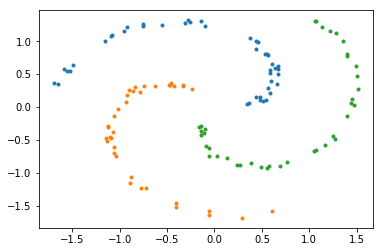

In [8]:
C = 3

def r(t):
    return t**0.5

N = 120
xdat = np.zeros((N,2))
ydat = np.zeros(N,dtype='int')
cnt = 0
while cnt < N :
    c = np.random.randint(0,C)
    ydat[cnt] = c
    tmp = 2.9*np.random.random() + 0.1
    xdat[cnt] = np.array([r(tmp)*np.cos(tmp+c*2*np.pi/3),r(tmp)*np.sin(tmp+c*2*np.pi/3)]) + 0.1*(np.random.random(2) -0.5)
    cnt += 1

tdat = np.zeros((N,C))
for c in range(C):
    tdat[:,c] = (ydat == c)
    plt.plot(xdat[np.where(ydat==c)][:,0],xdat[np.where(ydat==c)][:,1],'.')
plt.show()


We use a 2-layer neural network with logistic sigmoid activation function and softmax output function.

In [9]:
num_elements = np.array([2,3,3])

nn_2Dspiral = NN(num_elements,sigmoid,sigmoid_diff,softmax,E,lam=0.0)
nn_2Dspiral.fit(xdat,tdat)

0.0002163159841960683
True
Optimization terminated successfully.


The prediction of the classifier can be visualized as follows:

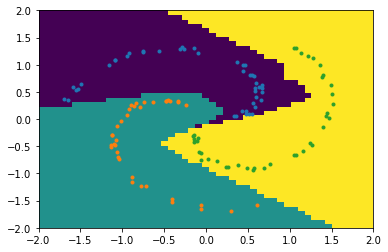

In [10]:
num0 = 50
num1 = 51
x0 = np.linspace(-2.0,2.0,num0)
x1 = np.linspace(-2.0,2.0,num1)
X0,X1 = np.meshgrid(x0,x1)

Xtest = np.zeros((np.size(X0),2))
Xtest[:,0] = np.reshape(X0,np.size(X0))
Xtest[:,1] = np.reshape(X1,np.size(X1))
                        
pred_label = nn_2Dspiral.pred_class(Xtest)
pred_label = np.reshape(pred_label,(num1,num0))

plt.pcolormesh(X0,X1, pred_label)
for c in range(C):
    tdat[:,c] = (ydat == c)
    plt.plot(xdat[np.where(ydat==c)][:,0],xdat[np.where(ydat==c)][:,1],'.')


## 6 Classifying hand written digits

As another example, here we apply the neural network to hand written digits.

In [11]:
digits = datasets.load_digits()

dat_train, dat_test, label_train, label_test = \
cross_validation.train_test_split(digits.data,digits.target)
t_train = np.zeros((len(label_train),10))
for c in range(10):
    t_train[:,c] = (label_train == c)

print(f"Training data : {len(dat_train)}")
print(f"Test data : {len(dat_test)}")

Training data : 1347
Test data : 450


In [12]:
num_elements = np.array([64,35,10])
nn_mnist = NN(num_elements, sigmoid, sigmoid_diff, softmax, E, lam=0.01)
nn_mnist.fit(dat_train,t_train)

0.0018703275243978196
True
Optimization terminated successfully.


In [14]:
label_test_pred = nn_mnist.pred_class(dat_test)
ac_score = metrics.accuracy_score(label_test, label_test_pred)
cl_report = metrics.classification_report(label_test, label_test_pred)
print(ac_score)
print(cl_report)

0.984444444444
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        48
          1       1.00      0.97      0.99        36
          2       0.98      0.98      0.98        46
          3       0.98      0.98      0.98        52
          4       0.98      1.00      0.99        54
          5       0.98      0.98      0.98        45
          6       0.97      1.00      0.99        38
          7       1.00      1.00      1.00        41
          8       0.97      0.95      0.96        41
          9       0.98      0.98      0.98        49

avg / total       0.98      0.98      0.98       450

